# Шаблон модели на LAMA

## 0. Предустановка

### 0.0. Установка LightAutoML и библиотек

In [1]:
# !pip install ipywidgets
# !pip install pandas-ta
# !pip install -U lightautoml==0.3.8b1
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn
# !pip install statsmodels
# !pip install moexalgo

### 0.1. Импорт библиотек

In [23]:
# Standard python libraries
import os

# Installed libraries
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pickle
import requests

# Imports from our package
from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.lgb_pipeline import LGBSeqSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearTrendFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import DictToPandasSeqReader
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.random_forest import RandomForestSklearn

from moexalgo import Market, Ticker

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

### 0.2. Константы и функции

Здесь мы настраиваем константы для использования в ядре:
- `HORIZON` - количество точек для прогноза 
- `TARGET_COLUMN` - 
имя целевого столбца в наборе данных
- `DATE_COLUMN` -
имя столбц с датойа в наборе данныхt

In [3]:
HORIZON = 5
TARGET_COLUMN = "close"
DATE_COLUMN = "date"

### 0.3. Загрузка данных

In [4]:
#Настройки
ticker_name = 'SBER'
period = '1D'
date_from = '2007-07-20'
date_to = '2023-12-05'

In [5]:
# Акции
ticker = Ticker(ticker_name)

# Свечи по акциям за период. Период в минутах 1, 10, 60 или '1m', '10m', '1h', 'D', 'W', 'M', 'Q'; по умолчанию 60
df = ticker.candles(date=date_from, till_date=date_to, period=period)

df.drop(['end'], axis=1, inplace=True)
df.rename(columns={"begin": "date"}, inplace=True)
df.tail()

[2023-12-06 22:23:00,494] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/columns.json "HTTP/1.1 200 OK"
[2023-12-06 22:23:00,833] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json "HTTP/1.1 200 OK"
[2023-12-06 22:23:02,033] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/SBER/candles.json?from=2007-07-20&till=2023-12-05&interval=24&start=0 "HTTP/1.1 200 OK"
[2023-12-06 22:23:02,466] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/SBER/candles.json?from=2007-07-20&till=2023-12-05&interval=24&start=500 "HTTP/1.1 200 OK"
[2023-12-06 22:23:02,975] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/SBER/candles.json?from=2007-07-20&till=2023-12-05&interval=24&start=1000 "HTTP/1.1 200 OK"
[2023-12-06 22:23:03,465] (INFO)

,open,close,high,low,value,volume,date
4092,279.36,276.80,280.56,276.20,8.285652e+09,29820830.0,2023-11-29
4093,276.70,277.50,278.65,272.75,1.539141e+10,55873540.0,2023-11-30
4094,277.00,273.97,277.98,273.55,8.726777e+09,31660970.0,2023-12-01
4095,273.60,270.96,274.95,270.52,1.027482e+10,37700740.0,2023-12-04
4096,271.98,279.62,279.65,270.54,1.289872e+10,46892570.0,2023-12-05


In [6]:
# список доступных индикаторов
df.ta.indicators()

# help(ta.bbands)

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [7]:
# Построение стратегии анализа с помо
MyStrategy = ta.Strategy(
    name="DCSMA10",
    ta=[
        {"kind": "ohlc4"},
        {"kind": "sma", "length": 3},
        {"kind": "sma", "length": 5},
        {"kind": "sma", "length": 10},
        {"kind": "sma", "length": 30},
        {"kind": "sma", "length": 50},
        {"kind": "donchian", "lower_length": 5, "upper_length": 5},
        {"kind": "ema", "close": "OHLC4", "length": 5, "suffix": "OHLC4"},
        {"kind": "ema", "close": "OHLC4", "length": 15, "suffix": "OHLC4"},
        {'kind': 'log_return', 'cumulative': True, 'append': True},
 {'kind': 'rsi', 'append': True},
 # {'kind': 'macd', 'append': True},
 # {'kind': 'mad', 'append': True},
 # {'kind': 'massi', 'append': True},
 # {'kind': 'mcgd', 'append': True},
 # {'kind': 'psar', 'append': True},
 # {'kind': 'qstick', 'append': True},
 # {'kind': 'quantile', 'append': True},
 # {'kind': 'rma', 'append': True},
 # {'kind': 'roc', 'append': True},
 #  {'kind': 'rsx', 'append': True},
 # {'kind': 'stoch', 'append': True},
 # {'kind': 'tsignals', 'append': True},
 # # {'kind': 'ttm_trend', 'append': True},
 # {'kind': 'xsignals', 'append': True},
 # # {'kind': 'zlma', 'append': True},
 # {'kind': 'zscore', 'append': True}
     ]
)

df.ta.strategy(MyStrategy, append=True)
df

,open,close,high,low,value,volume,date,OHLC4,SMA_3,SMA_5,SMA_10,SMA_30,SMA_50,DCL_5_5,DCM_5_5,DCU_5_5,CUMLOGRET_1,RSI_14
0,109.00,109.20,111.11,108.01,2.211623e+09,20252489.0,2007-07-20,109.3300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,109.70,112.00,112.65,108.10,3.901829e+09,35092029.0,2007-07-23,110.6125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025318,NaN
2,112.10,109.53,113.05,109.47,3.536964e+09,31762001.0,2007-07-24,111.0375,110.243333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003017,NaN
3,108.50,109.63,109.98,107.10,4.300853e+09,39700937.0,2007-07-25,108.8025,110.386667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003930,NaN
4,110.00,104.18,110.42,103.30,5.299123e+09,49871205.0,2007-07-26,106.9750,107.780000,108.908,NaN,NaN,NaN,103.30,108.175,113.05,-0.047061,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,279.36,276.80,280.56,276.20,8.285652e+09,29820830.0,2023-11-29,278.2300,279.680000,282.416,282.524,276.445333,270.0302,276.20,282.600,289.00,0.930114,48.747103
4093,276.70,277.50,278.65,272.75,1.539141e+10,55873540.0,2023-11-30,276.4000,278.070000,280.678,282.304,276.740333,270.5770,272.75,280.875,289.00,0.932640,49.987300
4094,277.00,273.97,277.98,273.55,8.726777e+09,31660970.0,2023-12-01,275.6250,276.090000,278.102,281.541,276.879333,271.0166,272.75,280.875,289.00,0.919838,44.181358
4095,273.60,270.96,274.95,270.52,1.027482e+10,37700740.0,2023-12-04,272.5075,274.143333,275.828,280.346,276.908000,271.3828,270.52,276.515,282.51,0.908790,39.923262


In [8]:
# Сделаем временной ряд непрерывным и смержим с датасетом
date = pd.DataFrame(pd.date_range(start=date_from, end=date_to), columns=['date'])
df = date.merge(df, how='left', on='date')

# Заполним пропуски с помощью интерполяции
for col in df.columns:
    if col == 'date':
        continue
    df[col] = df[col].interpolate(method='linear')

df.head(5)

,date,open,close,high,low,value,volume,OHLC4,SMA_3,SMA_5,SMA_10,SMA_30,SMA_50,DCL_5_5,DCM_5_5,DCU_5_5,CUMLOGRET_1,RSI_14
0,2007-07-20,109.000000,109.200000,111.110000,108.01,2.211623e+09,2.025249e+07,109.3300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,2007-07-21,109.233333,110.133333,111.623333,108.04,2.775025e+09,2.519900e+07,109.7575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008439,NaN
2,2007-07-22,109.466667,111.066667,112.136667,108.07,3.338427e+09,3.014552e+07,110.1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016879,NaN
3,2007-07-23,109.700000,112.000000,112.650000,108.10,3.901829e+09,3.509203e+07,110.6125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025318,NaN
4,2007-07-24,112.100000,109.530000,113.050000,109.47,3.536964e+09,3.176200e+07,111.0375,110.243333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003017,NaN


In [9]:
# Удалим строки с пустыми ячейками индикаторов
df = df.dropna()
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])
df.head()

,date,open,close,high,low,value,volume,OHLC4,SMA_3,SMA_5,SMA_10,SMA_30,SMA_50,DCL_5_5,DCM_5_5,DCU_5_5,CUMLOGRET_1,RSI_14
69,2007-09-27,101.810000,102.15,102.35,100.710000,5.368817e+09,5.275178e+07,101.755000,100.54,101.060,99.974000,96.546667,98.707600,98.45,101.00,103.55,-0.066739,58.274197
70,2007-09-28,102.180000,103.50,103.69,101.500000,4.182043e+09,4.067744e+07,102.717500,102.18,101.394,100.714000,96.836667,98.593600,98.45,101.07,103.69,-0.053609,60.718520
71,2007-09-29,102.386667,102.66,103.42,101.066667,4.011459e+09,3.916274e+07,102.383333,102.19,101.336,100.917667,96.923222,98.520133,98.45,101.07,103.69,-0.061826,58.586183
72,2007-09-30,102.593333,101.82,103.15,100.633333,3.840874e+09,3.764804e+07,102.049167,102.20,101.278,101.121333,97.009778,98.446667,98.45,101.07,103.69,-0.070042,56.453845
73,2007-10-01,102.800000,100.98,102.88,100.200000,3.670290e+09,3.613333e+07,101.715000,102.21,101.220,101.325000,97.096333,98.373200,98.45,101.07,103.69,-0.078259,54.321507


### 0.4. Разделение данных на train и test

In [10]:
test_start = df[DATE_COLUMN].values[-HORIZON]  

train = df[df[DATE_COLUMN] < test_start].copy()
test = df[df[DATE_COLUMN] >= test_start].copy()

# 1. Определение задачи модели

## 1.1. Тип задачи модели

В ячейке ниже мы создаем объект ```Task``` — класс для настройки того, какую задачу модель LightAutoML должна решать с конкретными потерями и метриками, если это необходимо (более подробную информацию можно найти [здесь](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) в документации LightAutoML). Для прогнозирования временных рядов его следует установить как «multi:reg»:

In [11]:
task = Task("multi:reg", greater_is_better=False, metric="mae", loss="mae")

multi:reg isn`t supported in lgb


## 1.2. Feature roles setup

Единственная роль, которую вы должны настроить, — это ```"target"``` р роль, все остальное (дата, категория и т. д.) зависит от пользователяия. Также мы можем определить сезонные особенности через DatetimeRole. Допустимы следующие значен`y`, `m`, `d`, `wd`, `hour`, `min`, `sec`, `ms`, `ns`.ns`.

In [12]:
roles = {
    "target": TARGET_COLUMN,
    DatetimeRole(seasonality=('m', 'wd'), base_date=True): DATE_COLUMN,
}

## 1.3. Создание модели LightAutoML (AutoTS)

Параметры которые мы можем установить:
- ```task``` - тип задачи ML (мы определили его ранее)
- ```seq_params``` - параметр для объекта Reader, который работает на первом этапе подготовки данных:
  - ```case``` - тип проблемы, которую мы решаем (```next_values```: прогнозирование следующих значений)
  - ```n_target``` - горизонт прогнозирования
  - ```history``` - размер истории для генерации признаков (т. е. признаки для наблюдения $y_t$ подсчитываются из наблюдений ($y_{t-history}$, ..., $y_{t-1}$))
  - ```step``` - в том, сколько точек взять следующее наблюдение в обучающей выборке (чем выше значение шага --> тем меньше наблюдений попадает в обучающую выборку)
  - ```test_last``` - технический параметр: тестовые данные строятся по последнему наблюдению из обучающей выборки.
  - ```from_last``` - технический параметр: построить признаки на основе последнего возможного наблюдения.
- ```transformers_params``` - параметр для объектов Transformer, которые необходимы для создания функций из необработанных временных рядов.
  - ```lag_features``` - *bool/int/list/array*: лаг признаки для признаков, отличных от даты
  - ```lag_time_features``` - *bool/int/list/array*: лаг признаки для дат
  - ```diff_features``` - *bool/int/list/array*: лаг изменений признаков, отличных от даты
- ```trend_params``` - параметр для объекта TrendModel, который необходим для удаления тренда временного ряда перед использованием основного класса AutoML. 

In [13]:
seq_params = {
    "seq0": {
        "case": "next_values",                  
        "params": {
            "n_target": HORIZON,                
            "history": HORIZON,                              
            "step": 1, 
            "from_last": True,
            "test_last": True
        }
    }
}

transformers_params = {
    "lag_features": 20,
    "lag_time_features": 20,
    "diff_features": [1, 2, 3, 4, 5, 6, 7, 14],
}

### Параметры для модели тренда.
trend_params = {
    'trend': True,
    'train_on_trend': True,
    'trend_type': 'decompose',  # one of 'decompose', 'decompose_STL', 'linear' or 'rolling'
    'trend_size': 3, 
    'decompose_period': 3, 
    'detect_step_quantile': 0.01, 
    'detect_step_window': 1, 
    'detect_step_threshold': 0.7,
    'rolling_size': 1, 
    'verbose': 0
}

automl = AutoTS(
    task,
    reader_params = {
        "seq_params": seq_params
    },
    rf_params={"default_params":{"criterion":"squared_error"}},
    time_series_trend_params=trend_params,
    time_series_pipeline_params=transformers_params,
    config_path=r"C:\Users\tdall\anaconda3\envs\py39\Lib\site-packages\lightautoml\automl\presets\time_series_config.yml"
)

**Important note**: `reader_params`, `time_series_trend_params`, `time_series_pipeline_params`, `general_params` keys are the YAML config keys, which is used inside `TabularAutoML` preset. More details on its structure with explanation comments can be found inside the `lightautoml/automl/presets/time_series_config.yaml` file. Each key from this config can be modified with user settings during both to providing .yml file and modifying while AutoTS class initialization like in the cell above. 

# 2. Обучение AutoML

## 2.1. LightAutoML

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [15]:
univariate_train_pred, _ = automl.fit_predict(train, roles, verbose=4)
forecast, _ = automl.predict(train)

[22:23:18] Stdout logging level is DEBUG.
[22:23:18] Task: multi:reg

[22:23:18] Start automl preset with listed constraints:
[22:23:18] - time: 3600.00 seconds
[22:23:18] - CPU: 4 cores
[22:23:18] - memory: 16 GB

[22:23:18] Layer 1 train process start. Time left 3599.83 secs
[22:23:19] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[22:23:19] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'squared_error'}
[22:23:19] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[22:23:37] Score for RF model: -0.591694
[22:23:37] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[22:23:52] Score for RF model: -0.601936
[22:23:52] Fitting Lvl_0_Pipe_0_Mod_0_RFSkle

Let's take a look on forecasts of univariate time series and check MAE

In [16]:
# Выведем результаты и MAE
print('pred:', forecast, "\n", "real:", test.close.values)
print(f"MAE: {mean_absolute_error(test.close, forecast)}")

pred: [275.33282 274.75415 273.9991  273.26022 272.5684 ] 
 real: [273.97       272.96666667 271.96333333 270.96       279.62      ]
MAE: 2.9075847167968734


Нарисуем график предсказаний модели в сравнении с истинными значениями

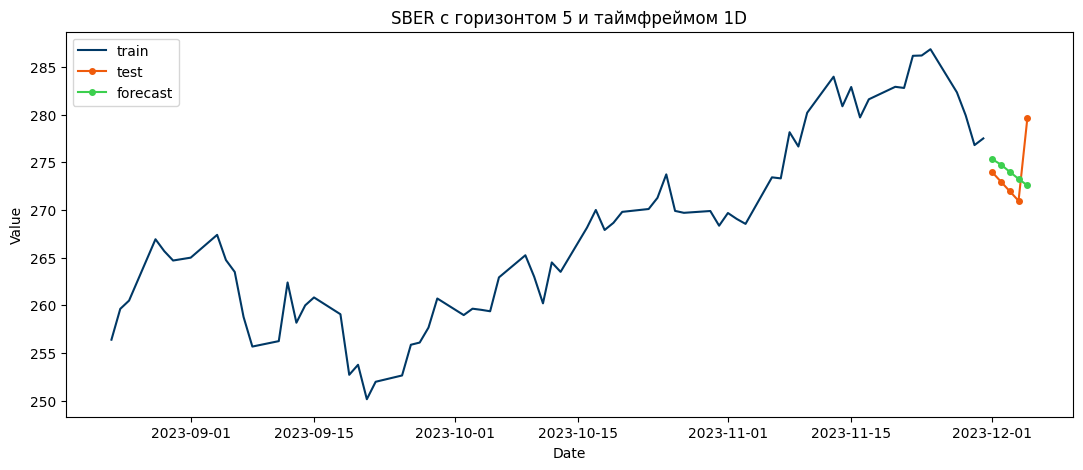

In [17]:
last_N = min(len(train), 100)

fig = plt.figure(figsize=(13, 5))
plt.plot(
    train[DATE_COLUMN][-last_N:], 
    train[TARGET_COLUMN][-last_N:], 
    c="#003865", 
    label="train"
)
plt.plot(
    test[DATE_COLUMN], 
    test[TARGET_COLUMN], 
    c="#EF5B0C", 
    label="test", 
    marker="o", 
    markersize=4
)
plt.plot(
    test[DATE_COLUMN], 
    forecast, 
    c="#3CCF4E", 
    label="forecast", 
    marker="o", 
    markersize=4
)

plt.xlabel("Date")
plt.ylabel("Value")
plt.title(f"{ticker_name} с горизонтом {HORIZON} и таймфреймом {period}")
plt.legend()
plt.show()

In [18]:
# Сохраним модель и запишем результат
with open(f"algomodels/{ticker_name}model_{HORIZON}.pickle", "wb") as f:
    pickle.dump(automl, f)

In [24]:
result =  [{
        "ticker": ticker_name,
        "predict_price": str(forecast[-1]),
        "predict_profit": str(forecast[-1]/test.close.values[-1] - 1),
        "timeframe": HORIZON
    }]

count = 0
while True:
    try:
        url = 'http://213.171.14.97:8080/api/v1/leaderboard'
        response = requests.post(url, json=result)
        if response.status_code == 200:
            print("Запрос успешно отправлен:")
            break
    except Exception as err:
        print("Ошибка отправка запроса на API:", err)

    # Делаем повторные попытки в случае ошибки
    if count >= 5:
        break

    count += 1

Запрос успешно отправлен:
